# Generate Plots from gb_catalog output

Ideas:
- Load up chain files post gb_catalog without regard for format (at least make specifying format easy)
- Plot pairs of variables (F/A, f/fdot, phi/theta) w/ confidence elipsses
- Plot injected values

# Import chain data from an analysis run
Need to provide the catalog directory after gb_mcmc and gb_catalog have both been run

In [1]:
# volume priors first run
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir30/catalog_16"
#volume_prior = True
#fdot = False

# prior to too many sources bug introduction
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir33/catalog_14"
#volume_prior = False
#fdot = False

# prior to too many sources bug introduction
# after first commit of refactor
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir36/catalog_15"
#volume_prior = False
#fdot = False

#Imediately after bug introduced
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir35/catalog_FIXME"
#volume_prior = False
#fdot = False

# After bug introduced and some code cleanup
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir37/catalog_19"
#volume_prior = False
#fdot = False

# After bug introduced but transpose of eigenvectors reverted
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir38/catalog_22"
#volume_prior = False
#fdot = False

# Adapted from GalacticBinaryWaveform.c
TSUN = 4.9255e-6
M_PI = 3.14159265358979323846
CLIGHT = 299792458.
PC = 3.0856775815e16

def galactic_binary_Mc(f, fd):
    pi83 = 21.170591578193 #pow(pi,8./3.)
    return ((fd/(96./5.)/pi83/(f**(11.0/3.0))) ** (3.0/5.0) )/TSUN

def galactic_binary_dL(f, fd, amp):
    return ((5./48.)*(fd/(M_PI*M_PI*f*f*f*amp))*CLIGHT/PC); #seconds  !check notes on 02/28!

def galactic_binary_fdot(Mc, f):
    M = Mc*TSUN
    Q = 19.2 # 96./5.
    return Q*(((M_PI**8)*(M**5)*(f**11))**(1./3.)); 

import numpy as np

def concat_column(recarray, column_values, column_dtype):
    old_shape = recarray.shape
    old_dtype = recarray.dtype
    new_dt = np.dtype(old_dtype.descr + [column_dtype])

    new_recarray = np.zeros(old_shape, dtype = new_dt)
    for param_name, _ in old_dtype.descr:
            new_recarray[param_name] = recarray[param_name]
    new_recarray[column_dtype[0]] = column_values
    return new_recarray

def concat_dfdtastro(recarray):
    dfdtastro_value = recarray["dfdt"] - galactic_binary_fdot(recarray["mc"], recarray["f0"])
    return concat_column(recarray, dfdtastro_value, ('dfdtastro', '<f8'))

In [18]:
import numpy as np

#catalog_dir = "/home/mtauraso/src/ldasoft/rundir47/catalog_14"
#volume_prior = False

catalog_dir = "/home/mtauraso/src/ldasoft/rundir48/catalog_17"
catalog_dir = "/home/mtauraso/src/ldasoft/rundir49/catalog_15"

# 6mo run with unitary probability distributed more anisotropically
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir50/catalog_14"

#First 6mo run w/ constrained fdot uniform prior (Has weirdly close source)
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir51/catalog_11"

# 1 yr run w/ constrained fdot uniform prior
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir52/catalog_13"

# 2nd 6mo run w/ constrained uniform prior
#catalog_dir = "/home/mtauraso/src/ldasoft/rundir53/catalog_15"


# 6mo run on fdot delta function w fixed signs
catalog_dir = "/home/mtauraso/src/ldasoft/rundir58/catalog_8"

catalog_dir = "/home/mtauraso/src/ldasoft/rundir62/catalog_12"

catalog_dir = "/home/mtauraso/src/ldasoft/rundir64/catalog_18"

volume_prior = True
fdot = False
catalog_dist_in_kpc = True
has_dfdt_astro = True



entries_layout = [('name', 'U64'), 
                  ('SNR', 'double'), 
                  ('Evidence','double')]

#catalog_dir = "/home/mtauraso/src/ldasoft/rundir18c/catalog_14"
#entries_layout = [('name', 'U64'),
#                  ('f0', 'double'), 
#                  ('SNR', 'double'), 
#                  ('Evidence','double'),
#                  ('folder', 'U64'),]

# see print_source_params for definition of this 
params_layout =[('f0', 'double'), # Principle frequency
                ('dfdt', 'double'), # Rate of frequency change
                ('amp', 'double'), # Amplitude
                ('phi', 'double'), # Sky location phi (ecliptic)
                ('costheta', 'double'), # Sky location costheta (ecliptic)
                ('cosi', 'double'), # Cos of inclination angle
                ('psi', 'double'), # Polarization angle
                ('phi0', 'double'), # Starting phase
                # Below are optional parameters commen tout the ones you don't need based on your run
                #
                ]
if volume_prior:
    params_layout.append(('mc', 'double')) # Chirp mass of source
    params_layout.append(('dist', 'double')) # Distance to source in parsecs
    if has_dfdt_astro:
        params_layout.append(('dfdtastro', 'double')) # Astrophysical contribution to dfdt (excluding GWs)

if fdot:
    params_layout.append(('d2fdt2', 'double')) # Second derivative of frequency

chain_layout = params_layout + [('SNR', 'double'),
                                ('wave_match', 'double'),
                                ('wave_dist', 'double'),
                                ]

entries = np.loadtxt(catalog_dir+"/entries.dat", dtype=entries_layout)

chains = {}
params = {}
max_freq = []
min_freq = []

for name in entries['name']:
    #name = name.decode('ascii')
    params[name] = np.loadtxt(catalog_dir+f"/{name}_params.dat", params_layout)
    chains[name] = np.loadtxt(catalog_dir+f"/{name}_chain.dat", chain_layout)
    max_freq.append(np.max(chains[name]["f0"]))
    min_freq.append(np.min(chains[name]['f0']))

    if volume_prior and not has_dfdt_astro:
        #dfdtastro_value = params[name]["dfdt"] - galactic_binary_fdot(params[name]["mc"], params[name]["f0"])
        #params[name] = concat_column(params[name], dfdtastro_value, ('dfdtastro', '<f8'))
        params[name] = concat_dfdtastro(params[name])
        chains[name] = concat_dfdtastro(chains[name])

max_freq = np.max(max_freq)
min_freq = np.min(min_freq)

print(params[entries[0]['name']])
# some debug printing to make sure we read everything in properly
#print(len(entries))
#print(len(chains[entries[0]['name']]))

#print(entries)
#print(params[entries[0]['name']])
#print(chains[entries[0]['name']][0])

(0.00399478, 5.53240432e-16, 3.28330845e-22, 3.51549059, -0.75544061, -0.34142813, 0.02583483, 5.85851008, 0.69476141, 2.48366695, 4.6269365e-17)


# Import LDC data
Provide the LDC data file below, right now this only works on radler data LDC1-4_GB_v2.hdf5
Also max and min frequency of the band to cut down on time taken processing

In [19]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

f = h5py.File("/home/mtauraso/src/LDC-data/LDC1-4_GB_v2.hdf5", 'r')
radler = True

all_injections = {}
det_injections = {}
int_injections = {}

if (radler):
    # Load detached binaries and compute m_c/dist
    #sources['Cadence'][()] # = 15 (I think this is the sampling rate)
    #f['H5LISA']['Simulation']['Cadence'][()] # = 15

    print(f['H5LISA']['GWSources']['GalBinaries']["ObservationDuration"][()]) # = 62914560.0 (seconds in observation time)

    #f['H5LISA']['GWSources']['GalBinaries']['Amplitude'].len() # = 29857650
    #np.greater(f['H5LISA']['GWSources']['GalBinaries']['FrequencyDerivative'],0.0).sum()

    sources = f['H5LISA']['GWSources']['GalBinaries']

    # Mask off everything outside our frequency range 
    freq_mask = np.logical_or(np.greater(sources['Frequency'][:], max_freq), np.less(sources['Frequency'][:], min_freq))

    all_injections['f0']= np.ma.masked_array(sources['Frequency'], mask = freq_mask).compressed()
    all_injections['amp'] = np.ma.masked_array(sources['Amplitude'][:], mask=freq_mask).compressed()
    all_injections['costheta'] = np.ma.masked_array(np.cos(np.pi/2 -sources['EclipticLatitude'][:]), mask=freq_mask).compressed()
    all_injections['phi'] = np.ma.masked_array(sources['EclipticLongitude'][:], mask=freq_mask).compressed()
    all_injections['cosi'] = np.ma.masked_array(np.cos(sources['Inclination'][:]), mask=freq_mask).compressed()
    all_injections['phi0'] = np.ma.masked_array(sources['InitialPhase'][:], mask=freq_mask).compressed()
    all_injections['psi'] = np.ma.masked_array(sources['Polarization'][:], mask=freq_mask).compressed()
    all_injections['dfdt'] = np.ma.masked_array(sources['FrequencyDerivative'][:], mask=freq_mask).compressed()

    # for Radler all binaries are mixed together, so we have to ID the detached ones
    mask = np.less(all_injections['dfdt'], 0.0)

    # calc detached parameters
    for key in all_injections.keys():
        det_injections[key] = np.ma.masked_array(all_injections[key], mask).compressed()
        int_injections[key] = np.ma.masked_array(all_injections[key], np.logical_not(mask)).compressed()
    
    det_injections['mc'] = galactic_binary_Mc(det_injections['f0'], det_injections['dfdt'])
    det_injections['dist'] = galactic_binary_dL(det_injections['f0'], det_injections['dfdt'], det_injections['amp'])
    det_injections['dfdtastro'] = np.zeros(shape = det_injections['dfdt'].shape)
    if (catalog_dist_in_kpc): det_injections['dist'] /= 1000.0 

#np.count_nonzero(np.isnan(mc))
print(np.max(det_injections['dist']), np.min(det_injections['dist']))
print(np.max(det_injections['mc']), np.min(det_injections['mc']))
#amp
#['Amplitude', 'EclipticLatitude', 'EclipticLongitude', 'Frequency', 'FrequencyDerivative', 'Inclination', 'InitialPhase', 'Polarization']



# Load interacting binaries



62914560.0
19.413801534254386 0.4478330092141568
0.5034419811662709 0.19133123508491695


In [20]:
for i,j in zip(det_injections["f0"],det_injections["amp"]):
    print(i,j)


0.003997283 1.209421e-23
0.003993697 5.957071e-23
0.003995221 3.971727e-22
0.003999279 3.914964e-23
0.004000592 1.579942e-23
0.004000911 1.914983e-23
0.00399845 1.288047e-23
0.003999943 1.565882e-23
0.004000475 4.983997e-24
0.003997629 5.419336e-23
0.003995152 7.829005e-24
0.003993994 1.573939e-23
0.003994621 1.248193e-22
0.004000572 1.610504e-23
0.003996676 1.664205e-22
0.003997718 7.976367e-24
0.003996828 4.763195e-23
0.003993683 9.801485e-24
0.003995 2.19746e-23
0.003998409 1.308586e-23
0.003995379 1.570017e-23
0.003994897 8.535125e-24


# Contour plots

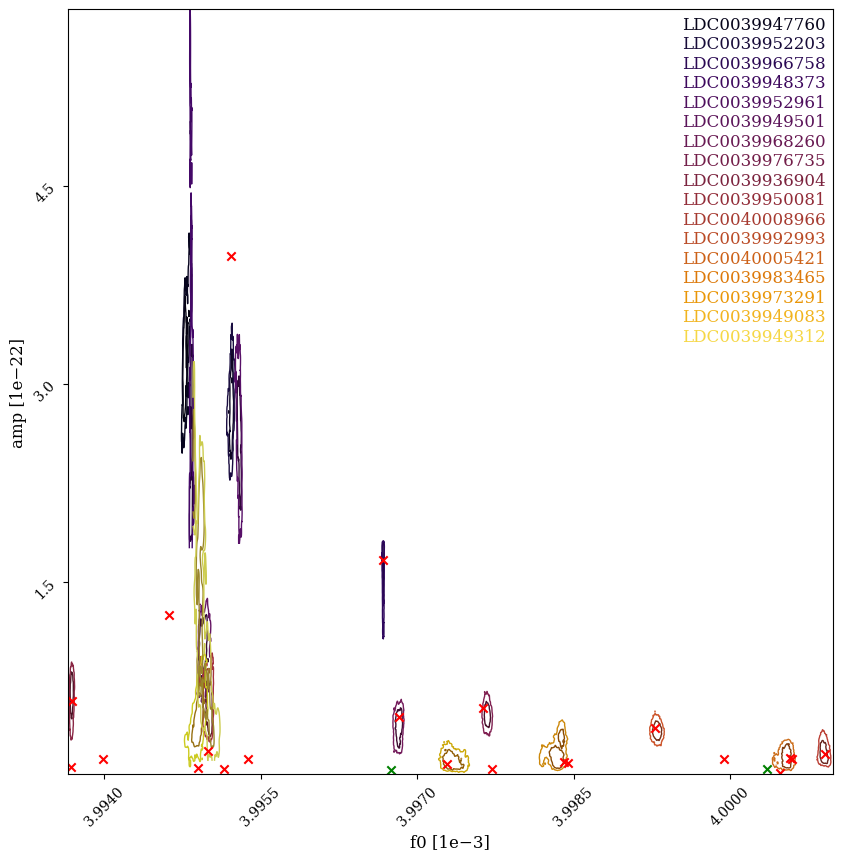

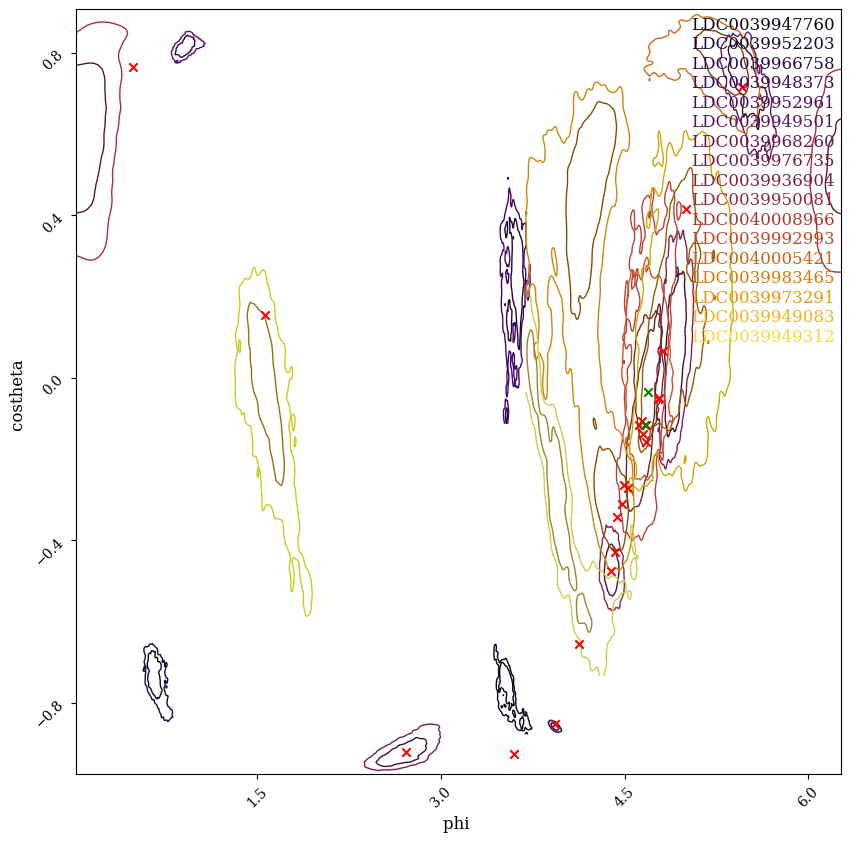

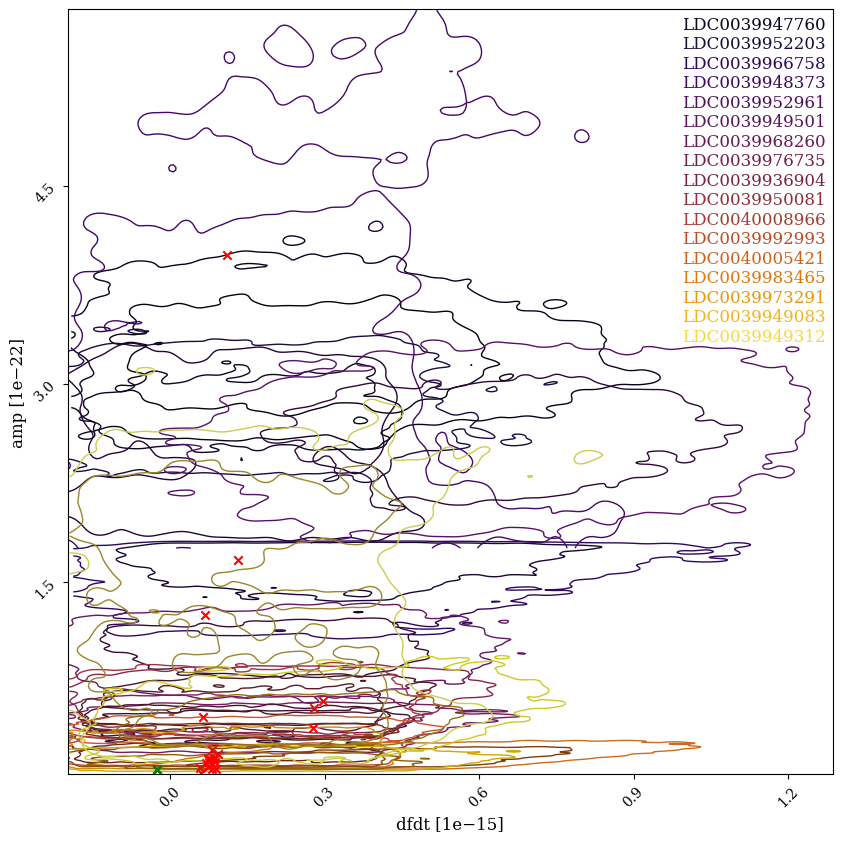

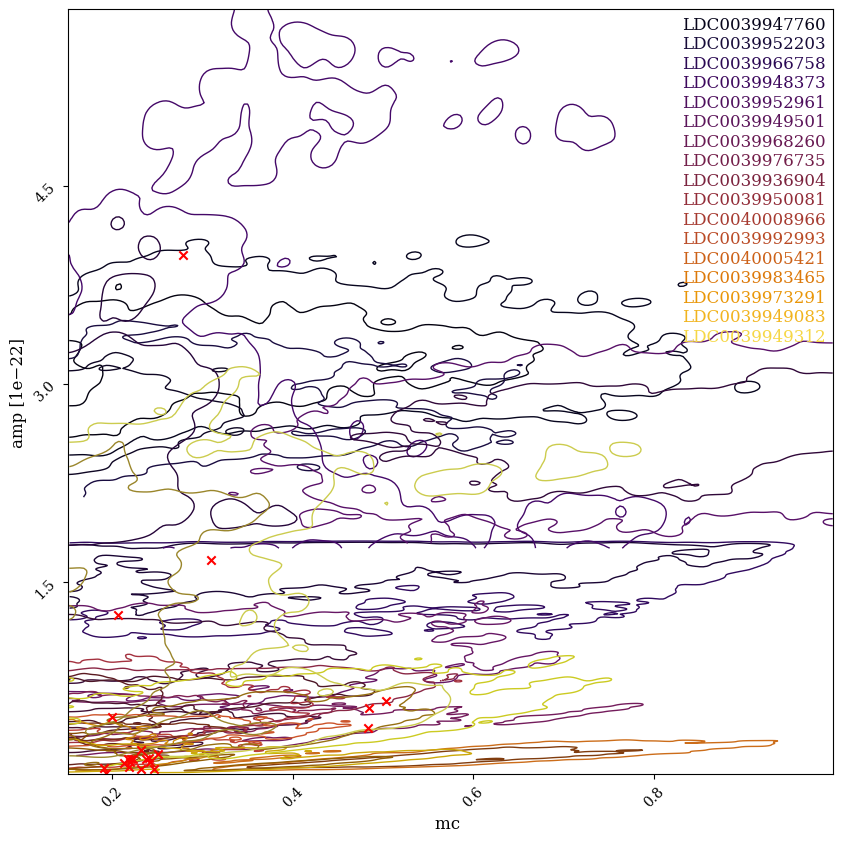

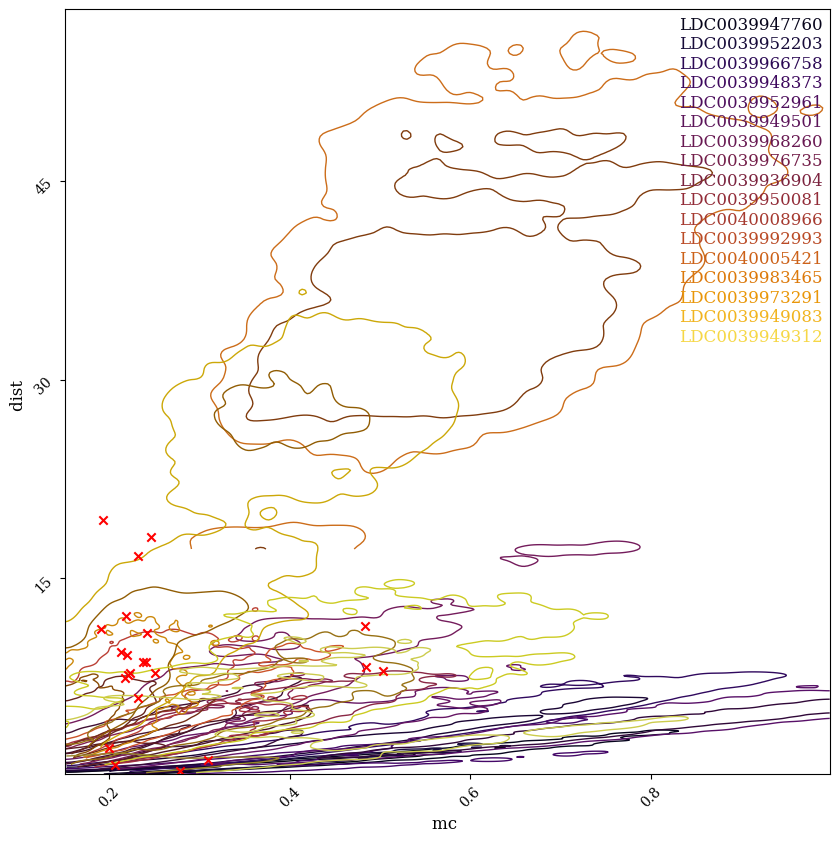

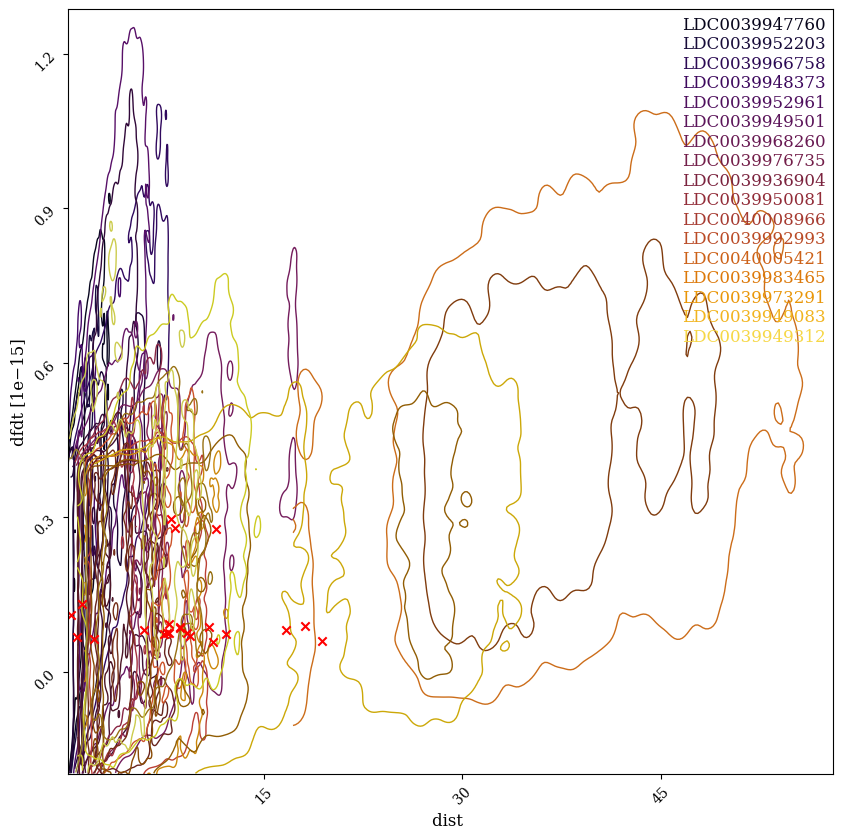

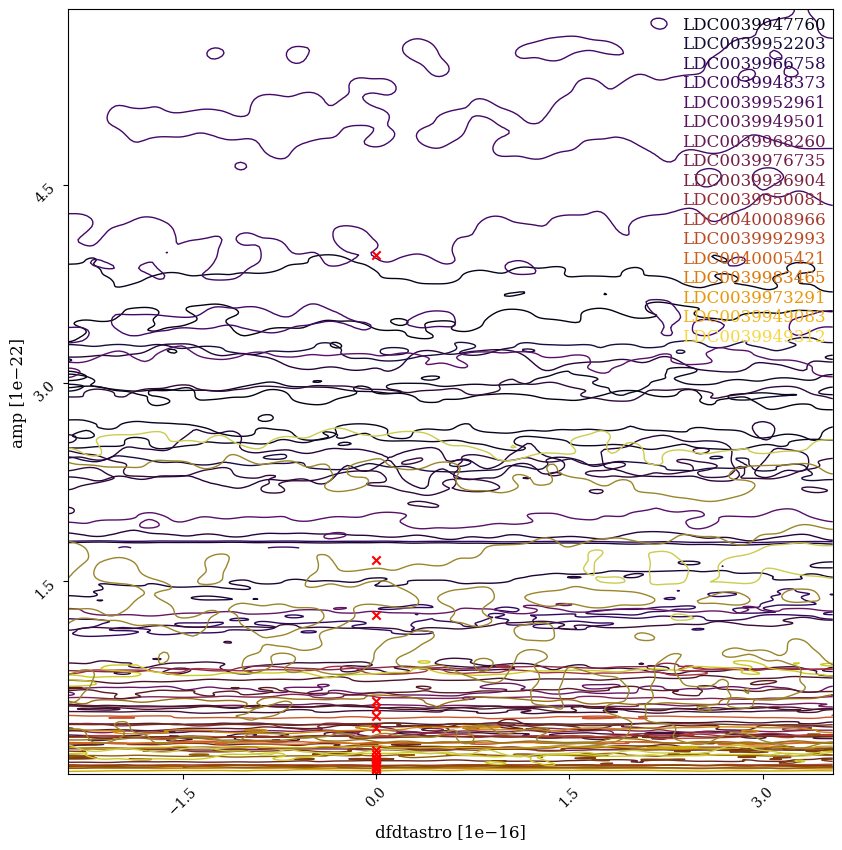

In [21]:
from chainconsumer import ChainConsumer

found_index = None
det_injection_index = None
int_injection_index = None

def plot_injection(ax, inj_dict, param_names, index, **kwargs):
    ax.set_xlim(auto=True)
    ax.set_ylim(auto=True)
    if(index == None):
        ax.scatter(inj_dict[param_names[0]], 
                   inj_dict[param_names[1]], **kwargs)
    else:
        ax.scatter(inj_dict[param_names[0]][index], 
                   inj_dict[param_names[1]][index], **kwargs)

def generate_contour_plot(param_names, **kwargs):
        c=ChainConsumer()
        for i, name in enumerate(entries['name']):
            if(found_index != None and found_index != i): continue
            chain = np.column_stack((chains[name][param_names[0]], chains[name][param_names[1]]))
            c.add_chain(chain, parameters=param_names, plot_contour=True, name=name)

        c.configure(plot_hists=False, usetex=False, 
            sigmas=[0,1,2])
        plot = c.plotter.plot(figsize=(9,9), log_scales=[False, False], display=False)
        ax = plot.axes[0]

        plot_injection(ax, det_injections, param_names, det_injection_index, marker="x", color="red")
        if ( "mc" not in param_names and "dist" not in param_names and "dfdtastro" not in param_names):
            plot_injection(ax, int_injections, param_names, int_injection_index, marker="x", color="green")
        

plot = generate_contour_plot(['f0','amp'])
plot = generate_contour_plot(['phi','costheta'])
plot = generate_contour_plot(['dfdt','amp'])
if(volume_prior): 
        plot = generate_contour_plot(['mc','amp'])
        plot = generate_contour_plot(['mc','dist'])
        plot = generate_contour_plot(['dist', 'dfdt'])
        plot = generate_contour_plot(['dfdtastro', 'amp'])

# Covariance ellipse plots

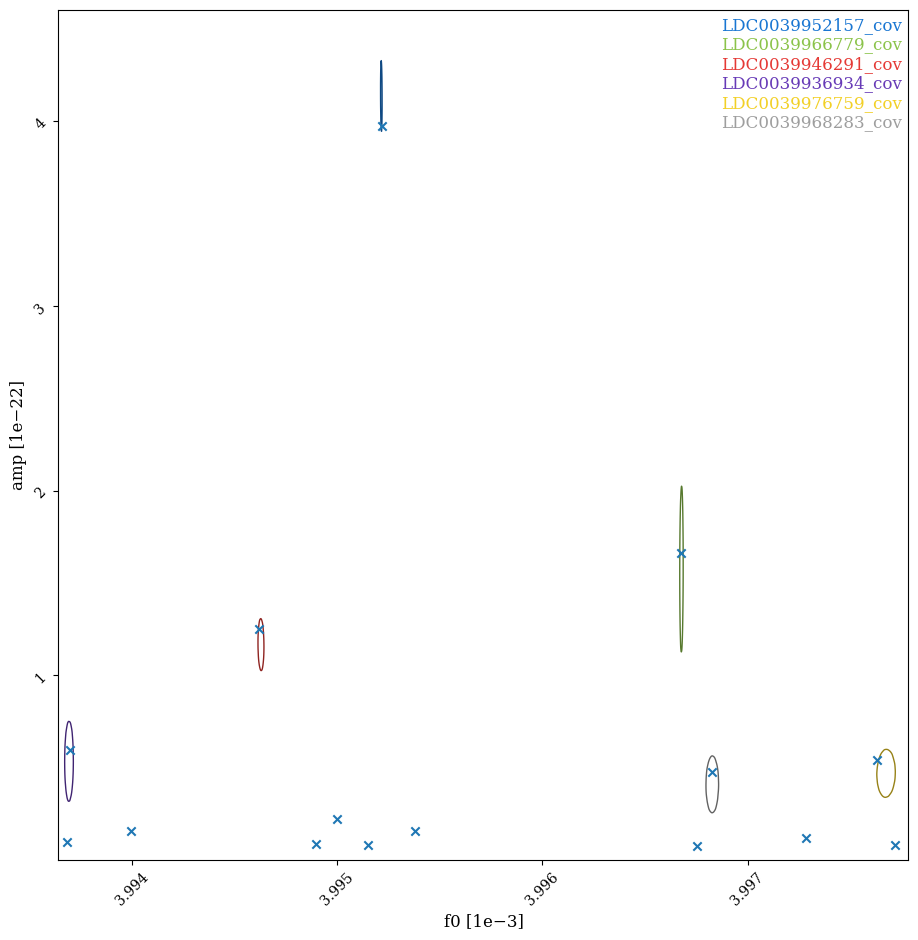

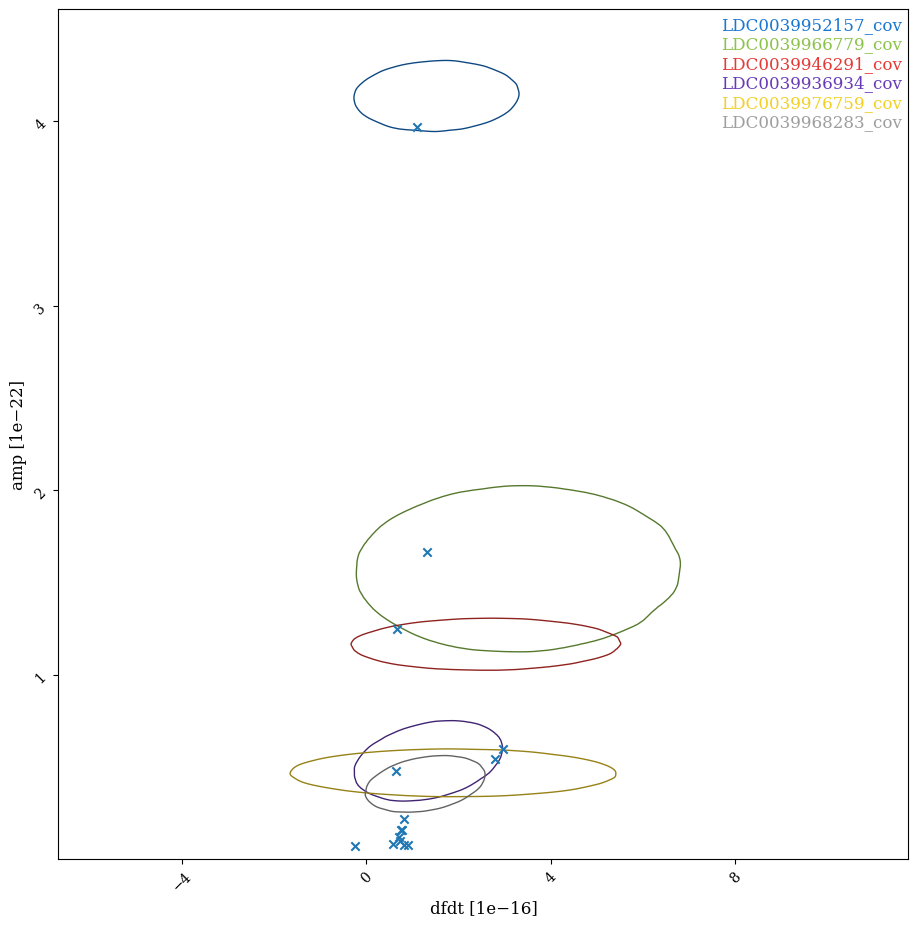

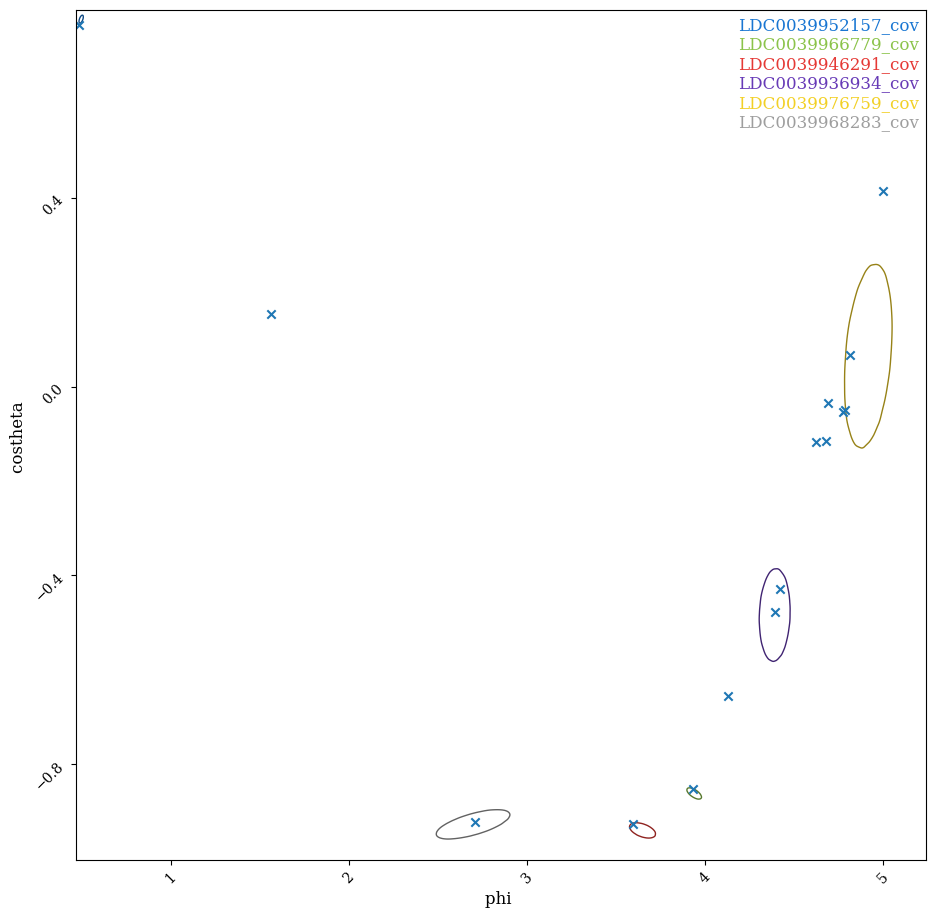

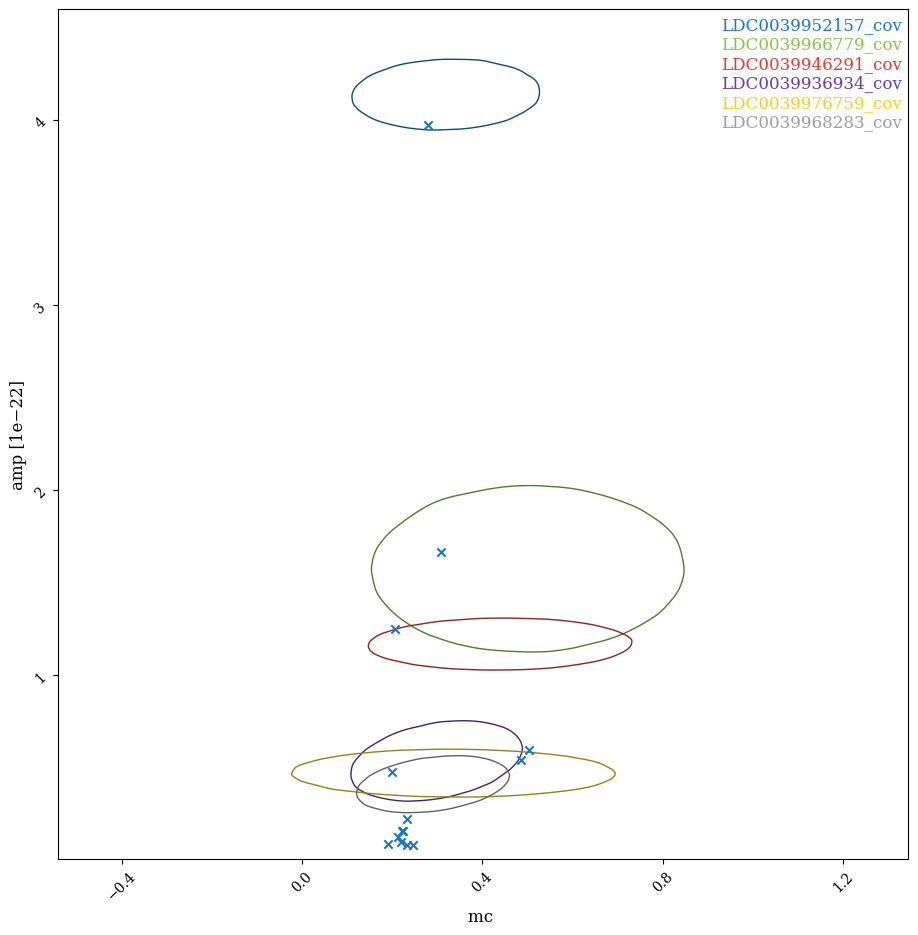

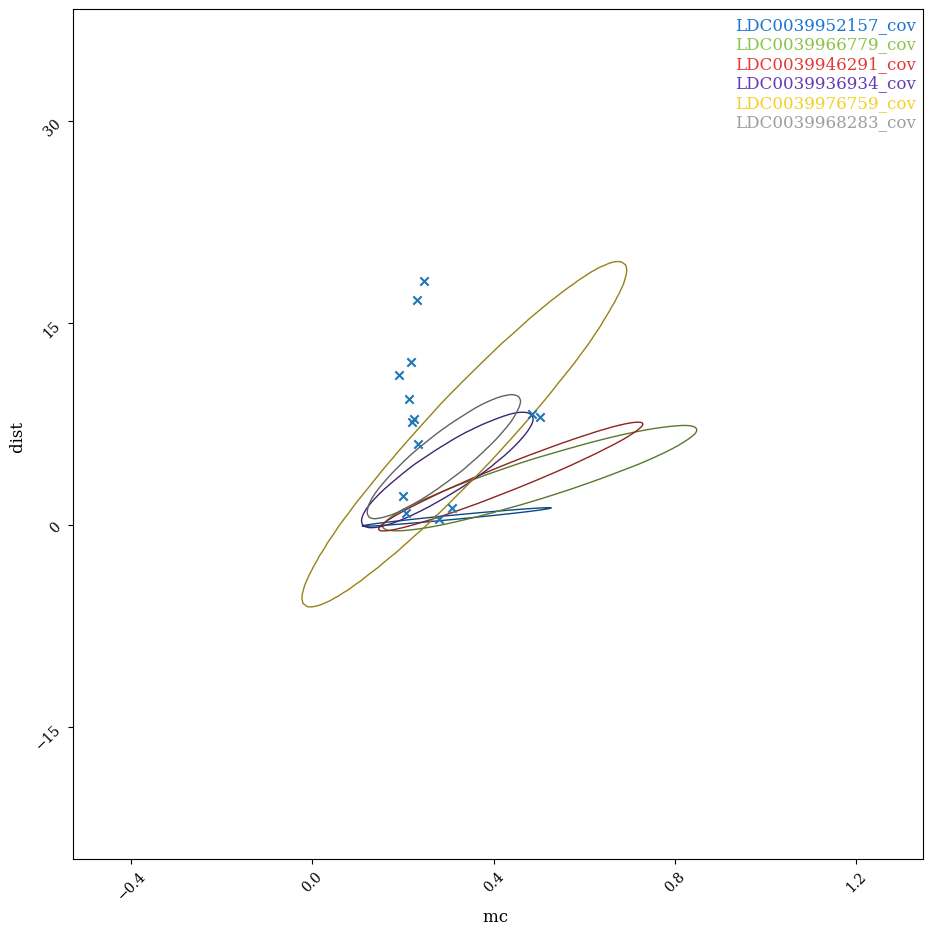

In [6]:
def generate_cov_plot(param_names, **kwargs):
    c=ChainConsumer()
    for i, name in enumerate(entries['name']):
            chain = np.column_stack((chains[name][param_names[0]], 
                                        chains[name][param_names[1]]))
            c.add_chain(chain, parameters=param_names, plot_contour=True, name=name)

    # There is some bug in chainconsumer where it won't plot if you add to many 
    # objects to it. This works around that limitation by making a new chainconsumer
    # just to hold the covariance elipses.
    d = ChainConsumer()
    for i, name in enumerate(entries['name']):
        cov_params, cov_matrix = c.analysis.get_covariance(i, parameters=param_names)
        #print(cov_matrix)
        mean_location = [params[name][param_names[0]],
                        params[name][param_names[1]]]
        mean_location = [ np.mean(chains[name][param_names[0]]),  
                          np.mean(chains[name][param_names[1]]) ]

        #d.add_marker(mean_location, parameters=param_names, name=f"{name}_center")
        d.add_covariance(mean_location, cov_matrix, parameters=param_names, name=f"{name}_cov")

    d.configure(plot_hists=False, 
                usetex=False, 
            sigmas=[0,1])
    
    plot = d.plotter.plot(figsize=(10,10), 
                      log_scales=[False, False], 
                      display = False,
                      #extents=[(3.9935e-3,4.003e-3),(-23.4,-21.6)]
                      )
    ax = plot.axes[0]
    inj_dict = det_injections if "mc" in param_names or "dist"in param_names else all_injections
    ax.scatter(inj_dict[param_names[0]], inj_dict[param_names[1]], marker="x")

plot = generate_cov_plot(['f0','amp'])
plot = generate_cov_plot(['dfdt','amp'])
plot = generate_cov_plot(['phi','costheta'])
if(volume_prior):
    plot = generate_cov_plot(['mc','amp'])
    plot = generate_cov_plot(['mc','dist'])

0.003993860429673977

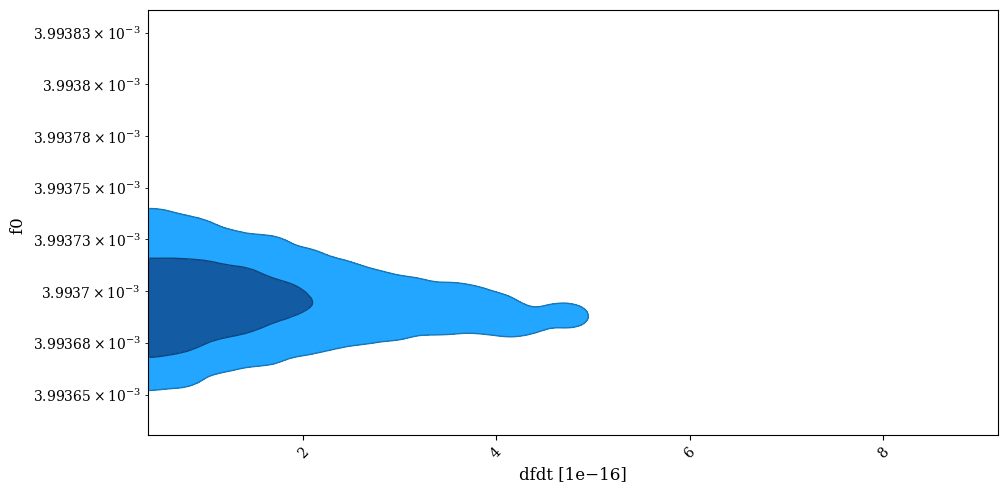

In [7]:
name=entries[3]['name']
param1 ="dfdt"
param2 ="f0"
c=ChainConsumer()
chain = np.column_stack((chains[name][param1], chains[name][param2]))
c.add_chain(chain, parameters=(param1, param2), name = name, plot_contour=True)
c.configure(plot_hists=False, usetex=False, sigmas=[0,1,2])
plot = c.plotter.plot(figsize=(10,5), log_scales=[False, True])

np.max(chains[name][param2])

In [8]:
import numpy as np
from chainconsumer import ChainConsumer


cov = [[1.0, 0.5, 0.2], [0.5, 2.0, 0.3], [0.2, 0.3, 3.0]]
data = np.random.multivariate_normal([0, 0, 1], cov, size=1000000)
print(data[10:])
parameters = ["x", "y", "z"]
c = ChainConsumer()
c.add_chain(data, parameters=parameters)
stuff, latex_table = c.analysis.get_covariance(1)
print(latex_table)

[[ 0.66379725  2.31065162  2.1609184 ]
 [ 0.53939791 -1.06565214  0.22834849]
 [ 0.61565429  1.1481776   2.23606474]
 ...
 [ 0.87832089 -1.02312455 -2.64056384]
 [ 0.54109818 -0.56888606 -2.21346539]
 [ 0.23044756 -0.15042468  1.1241688 ]]


AssertionError: Chain index 1 not found!